<a href="https://colab.research.google.com/github/bingblackbean/water_supply_network_pressure_pred_deepar/blob/main/water_pred_deepar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gluonts
!pip install mxnet
#!pip install -U mxnet-cu101==1.7.0

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
from collections import OrderedDict
from tqdm import tqdm,tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from pandas.api.types import CategoricalDtype
from sklearn.model_selection import TimeSeriesSplit
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
from gluonts.dataset.common import ListDataset
from gluonts.model import deepar
from gluonts.dataset.field_names import FieldName
import mxnet as mx
import random

r_seed = 2020
random.seed(r_seed)
mx.random.seed(r_seed)
np.random.seed(r_seed)

import gc
import warnings
warnings.filterwarnings("ignore")
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
G_THRESHOLD = 3.5
G_NOON = 15
G_MIDNIGHT = 3
G_SEASON_ON = [5,10]
G_LOG_FLAG= False
G_POST_LIST= [i+1 for i in range(30)]

In [ ]:
folder = '/content/gdrive/MyDrive/water_pred/' 
pressure_2018_df  = pd.read_csv(folder+'train_水压数据_2018.csv',encoding='utf8')
pressure_2019_df  = pd.read_csv(folder+'train_水压数据_2019.csv',encoding='utf8')
pressure_2020_df  = pd.read_csv(folder+'test_水压数据_2020.csv',encoding='utf8')
weather_2018_2019_df = pd.read_csv(folder+'2018-2019气象数据.csv',encoding='utf8')
weather_2020_df = pd.read_csv(folder+'2020气象数据.csv',encoding='utf8')
pressure_2018_2019_df = pd.concat([pressure_2018_df,pressure_2019_df],ignore_index=True)

to_predict_df_1st = pd.read_csv(folder+'to_predict.csv',encoding='utf8')

In [ ]:
def format_df(df):
    df['MeasName'] = pd.to_numeric(df['MeasName'].str.lstrip('站点'))
    df['Time'] =pd.to_datetime(df['Time'])
    return df

def reshape_pressure_df(df):
    # reshape to column-wise
    df_reshape = pd.DataFrame(None,columns=['DateTime','MeasName','Pressure'])
    for i in [i for i in range(24)]:
        per_hour_df = df[['Time','MeasName',f'H{i}']]
        per_hour_df['Time'] = per_hour_df['Time']+ pd.Timedelta(i,unit='h')
        per_hour_df.columns=['DateTime','MeasName','Pressure']   
        df_reshape = pd.concat([df_reshape,per_hour_df])
    df_reshape = pd.pivot_table(df_reshape, values='Pressure', index=['DateTime'],
                    columns=['MeasName'])
    return df_reshape

def dt_features(df):
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['weekday'] = df.index.dayofweek
    df['weeks'] = df.index.weekofyear
    df['month'] = df.index.month   
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['season_on'] = (df['month'] > G_SEASON_ON[0]) & (df['month'] < G_SEASON_ON[1])
    df['season_off'] = ~(df['month'] > G_SEASON_ON[0]) & (df['month'] < G_SEASON_ON[1])
    return df

def remove_abnormal(df):
    df[df[[i+1 for i in range(30)]]<=0.1] =None
    df[df[[i+1 for i in range(30)]]>=0.5] =None
    return df

def remove_abnormal_z_score(df,by_col='hour',th =3 ):
    for pos in tqdm(range(1,31,1)):
        df_zscore=df[[pos,by_col]].copy()
        f_zscores_all = pd.Series()
        for i in range(24):
            f_zscores=(df_zscore[df_zscore[by_col]==i][pos]-df_zscore[df_zscore[by_col]==i][pos].mean())/df_zscore[df_zscore[by_col]==i][pos].std()
            f_zscores_all= pd.concat([f_zscores_all,f_zscores])
        f_zscores_all.sort_index(inplace=True)
        df_zscore.loc[f_zscores_all.abs()> th,pos] = None # must use loc
        df[pos] = df_zscore[pos]
    return df

def remove_abnormal_zero_var(df,window =3,th=1e-07):
    for pos in tqdm(G_POST_LIST):
        df_pos=df[[pos]].copy()
        df_pos['var']=df_pos[pos].rolling(window=window,center=False).std()
        df_pos.loc[df_pos['var'] <= th,pos] = None # must use loc
        df[pos] = df_pos[pos]
    return df
def dt_features_for_submit(df): 
    df['hour'] = pd.to_numeric(df['Hour'].str.lstrip('H'))
    df['DateTime'] = df['Time']+ pd.to_timedelta(df['hour'], unit='h')
    df.drop('Hour',axis=1,inplace=True)
    df['day'] = df['Time'].dt.day
    df['weekday'] = df['Time'].dt.dayofweek
    df['weeks'] = df['Time'].dt.weekofyear
    df['month'] = df['Time'].dt.month   
    df['quarter'] = df['Time'].dt.quarter
    df['year'] = df['Time'].dt.year
    df['season_on'] = (df['month'] > G_SEASON_ON[0]) & (df['month'] < G_SEASON_ON[1])
    df['season_off'] = ~(df['month'] > G_SEASON_ON[0]) & (df['month'] < G_SEASON_ON[1])
    return df
def preproc_df(df):
    df = format_df(df)
    df = reshape_pressure_df(df)
    df = remove_abnormal(df)
    df =dt_features(df)
    df = remove_abnormal_z_score(df,th =G_THRESHOLD)
    df = remove_abnormal_zero_var(df,window =3,th=1e-07)

    return df

def preproc_submit_df(df):
    df = format_df(df)
    df = dt_features_for_submit(df)
    return df
pressure_2018_2019_df = preproc_df(pressure_2018_2019_df)
pressure_2020_df = preproc_df(pressure_2020_df)
to_predict_df_1st = preproc_submit_df(to_predict_df_1st)
print(pressure_2018_2019_df.shape)
print(pressure_2020_df.shape)
print(to_predict_df_1st.shape)

100%|██████████| 30/30 [00:00<00:00, 335.72it/s]

(17520, 39)
(2976, 39)
(40320, 13)


In [ ]:
def group_by_period(df,period_col):
    df_group= df[[i+1 for i in range(30)]+[period_col]].groupby(period_col).mean()
    return df_group

def proc_weather_temp(df):
    df[['weather1','weather2']] = df['天气'].str.split('转', 2, expand=True)
    df['weather1'].replace('',np.nan,inplace=True)
    df['weather2'].replace('',np.nan,inplace=True)
    df['weather2'].fillna(df['weather1'],inplace=True)
    df['weather1'].fillna(df['weather2'],inplace=True)
    df[['high_temp','low_temp']] = df['气温'].str.split('～', 2, expand=True)
    df['high_temp']= df['high_temp'].str.strip('C ℃') # must include space in the string
    df['low_temp']= df['low_temp'].str.strip('C ℃') # must include space in the string
    df['high_temp'].replace('',np.nan,inplace=True)
    df['high_temp'] = df['high_temp'].fillna(df['low_temp']).astype(int)
    df['low_temp'] = df['low_temp'].fillna(df['high_temp']).astype(int)
    df = df.drop(['天气','气温','风向'],axis=1).rename({'日期':'DateTime'},axis=1)
    df['DateTime'] =pd.to_datetime(df['DateTime'])
    df = df.set_index('DateTime').sort_index()
    return df

def resample_weather(df,last_day):
    last_day = pd.Timestamp(last_day)
    next_day = pd.Timestamp(last_day) + pd.Timedelta(1,'D')
    df.loc[pd.Timestamp(next_day)] = df.loc[last_day] 
    df_resample = df[['weather1','weather2','high_temp','low_temp']].resample(rule='H').interpolate('pad')
    df_resample['hour'] = df_resample.index.hour
    df_resample.loc[df_resample['hour']!=G_NOON,'high_temp']= None
    df_resample.loc[df_resample['hour']!=G_MIDNIGHT,'low_temp']= None
    df_resample['temp'] = df_resample[['high_temp','low_temp']].max(axis=1)
    df_resample['temp'].interpolate('linear',inplace=True)
    df_resample['temp'].fillna(method='bfill',inplace=True)
    return df_resample[['weather1','weather2','temp']]

def encoding_weather(df):
    weather_list = ['小雪', '小到中雪','中到大雪', '大雪', '扬沙', '多云', '晴', '阴', '雾', '雨夹雪','雷阵雨', '阵雨', '雨','小雨', '小到中雨','中雨', '中到大雨','大雨',  '暴雨']
    weather_type = CategoricalDtype(categories=weather_list,ordered=True)
    df['weather1'] = df['weather1'].astype(weather_type).cat.codes
    df['weather2'] = df['weather2'].astype(weather_type).cat.codes
    return df

weather_2018_2019_df = proc_weather_temp(weather_2018_2019_df)
weather_2020_df = proc_weather_temp(weather_2020_df)
weather_2018_2019_df_resample = resample_weather(weather_2018_2019_df,'2019-12-31')
weather_2020_df_resample = resample_weather(weather_2020_df,'2020-11-09')
weather_2018_2019_df_resample = encoding_weather(weather_2018_2019_df_resample)
weather_2020_df_resample = encoding_weather(weather_2020_df_resample)

In [ ]:
pressure_2018_2019_df = pd.merge(left=pressure_2018_2019_df,right=weather_2018_2019_df_resample,left_index=True, right_index=True,how='left')
print(pressure_2018_2019_df.head())
pressure_2020_df = pd.merge(left=pressure_2020_df,right=weather_2020_df_resample,left_index=True, right_index=True,how='left')
print(pressure_2020_df.head())

                            1        2         3  ...  weather1  weather2      temp
DateTime                                          ...                              
2018-01-01 00:00:00  0.288625  0.31775  0.301375  ...         5         5 -4.000000
2018-01-01 01:00:00  0.292000  0.31925  0.303250  ...         5         5 -4.000000
2018-01-01 02:00:00  0.290500  0.32000  0.302125  ...         5         5 -4.000000
2018-01-01 03:00:00  0.299500  0.32150  0.303250  ...         5         5 -4.000000
2018-01-01 04:00:00  0.300250  0.32675  0.307000  ...         5         5 -3.583333

[5 rows x 42 columns]
                            1         2         3  ...  weather1  weather2      temp
DateTime                                           ...                              
2020-01-01 00:00:00  0.309625  0.343250  0.324125  ...         5         5 -2.000000
2020-01-01 01:00:00  0.325750  0.359375  0.341000  ...         5         5 -2.000000
2020-01-01 02:00:00  0.332875  0.362750  0.348125

In [ ]:
def fill_gap_by_previous_window(df,windows=7*24): # if happenly last previous period has smilar missing gap, it is hard to fill (so try run this funtion multiple times)
    for pos in G_POST_LIST:
        last_score = 0
        while df.iloc[windows:,:][pos].isna().sum() !=0: # don;t need to check first window (we cannot fill this period)
            if last_score == df.iloc[windows:,:][pos].isna().sum():
                break
            else:
                pf_df = df[[pos]]
                pf_df['yhat'] = pf_df[pos].shift(windows)
                pf_df[pos].fillna(pf_df['yhat'],inplace=True)
                df[pos] = pf_df[pos]
            last_score = df.iloc[windows:,:][pos].isna().sum()
    return df
for i in tqdm(range(100)):
    pressure_2018_2019_df = fill_gap_by_previous_window(pressure_2018_2019_df,windows=7*24)

100%|██████████| 100/100 [00:02<00:00, 42.64it/s]


In [ ]:
pressure_2020_df.isna().sum()
for i in tqdm(range(100)):
    pressure_2020_df = fill_gap_by_previous_window(pressure_2020_df,windows=7*24)

100%|██████████| 100/100 [00:02<00:00, 48.36it/s]


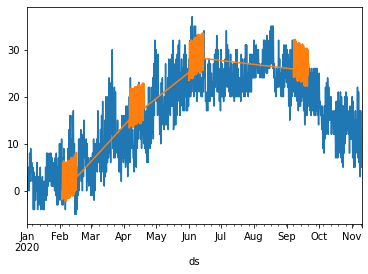

In [ ]:
# predict temperature
from fbprophet import Prophet
temp_model = Prophet(yearly_seasonality=True,changepoint_prior_scale=0.01,seasonality_prior_scale=100)
temp_df =weather_2018_2019_df_resample[['temp']]
temp_df['ds'] = temp_df.index  
temp_df.rename({'temp': 'y'}, axis=1, inplace=True) 
temp_model.fit(temp_df)

to_predict_1st_gr = to_predict_df_1st.groupby('DateTime').mean()
to_predict_1st_gr['ds'] = to_predict_1st_gr.index  
to_predict_1st_temp_yhat = temp_model.predict(to_predict_1st_gr)
to_predict_1st_temp_yhat.set_index('ds',inplace=True,drop=False)
weather_2020_df_resample['temp'].plot()
to_predict_1st_temp_yhat['yhat'].plot()

In [ ]:
to_predict_temp_date_df = pd.DataFrame()
for ds in ['2020-02-01','2020-04-01','2020-06-01','2020-09-01']:
    temp_date_df = pd.DataFrame()
    temp_date_df['ds']=[pd.Timestamp(ds)+pd.Timedelta(i,unit='H') for i in range(21*24)]
    to_predict_temp_date_df = pd.concat([to_predict_temp_date_df,temp_date_df],axis=0)

to_predict_1st_temp_yhat = temp_model.predict(to_predict_temp_date_df)
to_predict_1st_temp_yhat['DateTime'] = to_predict_1st_temp_yhat['ds']
to_predict_1st_temp_yhat.set_index('DateTime',inplace=True,drop=True)
pressure_2020_df = pd.merge(left=pressure_2020_df,right=to_predict_1st_temp_yhat[['yhat']],left_index=True,right_index=True,how='outer')
pressure_2020_df['temp'].fillna(pressure_2020_df['yhat'],inplace=True)

In [ ]:
def diff_pos(df,pos_list,periods=1):
    diff_df = df.copy()
    for c in df.columns:
        if c in pos_list:
            diff_df[c] = df[c].diff(periods=periods)
        else:
            diff_df[c] = df[c]
    return diff_df

In [ ]:
diff_periods = 21*24
pressure_2020_df_diff = diff_pos(pressure_2020_df,G_POST_LIST,diff_periods)
pressure_2018_2019_df_diff = diff_pos(pressure_2018_2019_df,G_POST_LIST,diff_periods)

In [ ]:
pressure_2020_df_diff[1].head()

DateTime
2020-01-01 00:00:00   NaN
2020-01-01 01:00:00   NaN
2020-01-01 02:00:00   NaN
2020-01-01 03:00:00   NaN
2020-01-01 04:00:00   NaN
Name: 1, dtype: float64

In [ ]:
pressure_2020_df[1].head()

DateTime
2020-01-01 00:00:00    0.309625
2020-01-01 01:00:00    0.325750
2020-01-01 02:00:00    0.332875
2020-01-01 03:00:00    0.324250
2020-01-01 04:00:00    0.331750
Name: 1, dtype: float64

In [ ]:
pressure_2018_2019_df_diff.loc['2018-06':'2019-10',1]

DateTime
2018-06-01 00:00:00    0.013875
2018-06-01 01:00:00    0.026625
2018-06-01 02:00:00    0.031500
2018-06-01 03:00:00    0.034500
2018-06-01 04:00:00    0.036375
                         ...   
2019-10-31 19:00:00    0.003750
2019-10-31 20:00:00   -0.007500
2019-10-31 21:00:00   -0.000750
2019-10-31 22:00:00    0.001125
2019-10-31 23:00:00    0.005250
Name: 1, Length: 12432, dtype: float64

In [ ]:
# final model
freq = "1H"
prediction_length = 21*24
context_length = 28*24
print(f'seed is {r_seed}')
mx.random.seed(r_seed)
np.random.seed(r_seed)

use_diff_2018_2019_df = pressure_2018_2019_df_diff

pos_group_dict = {1:6,2:0,3:6,4:0,5:6,6:4,7:6,8:0,9:4,10:4,11:5,12:6,13:6,14:2,15:1,16:3,17:7,18:6,19:6,20:6,21:6,22:5,23:4,24:4,25:6,26:5,27:5,28:6,29:6,30:5}
pos_group_dict = {1:1,2:0,3:1,4:0,5:1,6:1,7:1,8:0,9:1,10:1,11:1,12:1,13:1,14:1,15:1,16:1,17:1,18:1,19:1,20:1,21:1,22:1,23:1,24:1,25:1,26:1,27:1,28:1,29:1,30:1}
pos_group_dict = {1:1,2:1,3:1,4:1,5:1,6:1,7:1,8:1,9:1,10:1,11:1,12:1,13:1,14:1,15:1,16:1,17:1,18:1,19:1,20:1,21:1,22:1,23:1,24:1,25:1,26:1,27:1,28:1,29:1,30:1}

train_ds = ListDataset([{'target': use_diff_2018_2019_df.loc['2018-06':'2019-10',pos], 'start': pd.Timestamp("2018-06-01", freq=freq),FieldName.FEAT_DYNAMIC_REAL: use_diff_2018_2019_df.loc['2018-06':'2019-10',['temp']].values.T,FieldName.FEAT_STATIC_CAT:[pos_group_dict[pos]]} for pos in G_POST_LIST]
                        ,
                    freq=freq)
validate_ds = ListDataset([{'target': use_diff_2018_2019_df.loc['2019-11':'2019-12',pos], 'start': pd.Timestamp("2019-11-01", freq=freq),FieldName.FEAT_DYNAMIC_REAL: use_diff_2018_2019_df.loc['2019-11':'2019-12',['temp']].values.T,FieldName.FEAT_STATIC_CAT:[pos_group_dict[pos]]} for pos in G_POST_LIST]
                        ,
                    freq=freq)
trainer = Trainer(epochs=10,batch_size=128,num_batches_per_epoch=20,patience=5)
estimator = deepar.DeepAREstimator(
    freq=freq, prediction_length=prediction_length, trainer=trainer,context_length=context_length,use_feat_dynamic_real =True,num_layers=2,num_cells=40,use_feat_static_cat  =True,cardinality=[30])
predictor = estimator.train(training_data=train_ds)#,validation_data=validate_ds)


INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
  0%|          | 0/20 [00:00<?, ?it/s]

seed is 2020
learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


INFO:gluonts.trainer:Number of parameters in DeepARTrainingNetwork: 30493
100%|██████████| 20/20 [01:40<00:00,  5.05s/it, epoch=1/10, avg_epoch_loss=-2.45]
INFO:gluonts.trainer:Epoch[0] Elapsed time 100.938 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=-2.454587
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 20/20 [01:06<00:00,  3.33s/it, epoch=2/10, avg_epoch_loss=-2.72]
INFO:gluonts.trainer:Epoch[1] Elapsed time 66.658 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=-2.717111
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 20/20 [01:05<00:00,  3.30s/it, epoch=3/10, avg_epoch_loss=-2.79]
INFO:gluonts.trainer:Epoch[2] Elapsed time 65.908 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=-2.787063
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|██████████| 20/20 [01:08<00:00,  3.43s/it, epoch=4/10, avg_epoch_loss=-2.84]
INFO:gluonts.trainer:Epoch[3] Elapsed time 68.532 s

In [ ]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=validate_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=prediction_length,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)
from gluonts.evaluation import Evaluator
import json
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=30)
print(json.dumps(agg_metrics, indent=4))

Running evaluation: 100%|██████████| 30/30 [00:00<00:00, 330.09it/s]


{
    "MSE": 0.0005453580232810171,
    "abs_error": 226.15096831321716,
    "abs_target_sum": 231.29268169403076,
    "abs_target_mean": 0.015297135032673992,
    "seasonal_error": 0.015220939501737935,
    "MASE": 0.919820733592805,
    "MAPE": 1.8178296259532585,
    "sMAPE": 1.3464665278145218,
    "OWA": NaN,
    "MSIS": 7.583472066906375,
    "QuantileLoss[0.1]": 106.48217725639695,
    "Coverage[0.1]": 0.06263227513227512,
    "QuantileLoss[0.5]": 226.15097398629496,
    "Coverage[0.5]": 0.4337962962962963,
    "QuantileLoss[0.9]": 125.51869844846661,
    "Coverage[0.9]": 0.8912037037037037,
    "RMSE": 0.023352901817140777,
    "NRMSE": 1.5266193157908348,
    "ND": 0.9777696667998541,
    "wQuantileLoss[0.1]": 0.4603784973934394,
    "wQuantileLoss[0.5]": 0.9777696913275553,
    "wQuantileLoss[0.9]": 0.5426833980614701,
    "mean_absolute_QuantileLoss": 152.7172832303862,
    "mean_wQuantileLoss": 0.660277195594155,
    "MAE_Coverage": 0.037455908289241634
}


In [ ]:
print('validating...')
all_df = pd.DataFrame()

valid_start_date = pd.Timestamp('2019-11-01')
valid_end_date = valid_start_date + pd.Timedelta(int(context_length/24-1),unit='D')
pred_start_date = valid_end_date + pd.Timedelta(1,unit='D')
pred_end_date  = pred_start_date + pd.Timedelta(int(prediction_length/24-1),unit='D')
for pos in G_POST_LIST:
    out = pd.DataFrame()
    mx.random.seed(r_seed)
    np.random.seed(r_seed)
    validate_ds_pred = ListDataset([{'target': use_diff_2018_2019_df.loc[valid_start_date.strftime('%Y-%m-%d'):valid_end_date.strftime('%Y-%m-%d'),pos],
                                     'start': pd.Timestamp(pred_start_date.strftime('%Y-%m-%d'), freq=freq),
                                     FieldName.FEAT_DYNAMIC_REAL: use_diff_2018_2019_df.loc[valid_start_date.strftime('%Y-%m-%d'):pred_end_date.strftime('%Y-%m-%d'),['temp']].values.T,FieldName.FEAT_STATIC_CAT:[pos_group_dict[pos]]}]
                        ,
                    freq=freq)
    prediction = next(predictor.predict(validate_ds_pred))
    yhat_mean = prediction.mean
    out['y'] = use_diff_2018_2019_df.loc[pred_start_date.strftime('%Y-%m-%d'):pred_end_date.strftime('%Y-%m-%d'),pos]
    out['yhat'] = yhat_mean.tolist()
    out['station']=pos
    all_df = pd.concat([all_df,out],axis=0)
    calc_pred = all_df.dropna(subset=['y','yhat'],axis=0)
    error = mean_squared_error(calc_pred[calc_pred['station']==pos]['y'],calc_pred[calc_pred['station']==pos]['yhat'])*10000
    print(f'stations {pos} error is {error}')
calc_pred = all_df.dropna(subset=['y','yhat'],axis=0)
error = mean_squared_error(calc_pred['y'],calc_pred['yhat'])*10000
print('*'*20)
print(f'mean error is {error}')


validating...
stations 1 error is 0.6769553857155235
stations 2 error is 0.6207287347495963
stations 3 error is 0.6482384826291122
stations 4 error is 4.391913442923201
stations 5 error is 0.8164678137763461
stations 6 error is 17.39289953740009
stations 7 error is 2.068074754200214
stations 8 error is 2.8413219280248354
stations 9 error is 16.0451127065489
stations 10 error is 6.6941715614935715
stations 11 error is 3.888358395277318
stations 12 error is 3.017441948751569
stations 13 error is 22.053681366945195
stations 14 error is 2.3318049609372387
stations 15 error is 33.07338653292795
stations 16 error is 1.992728112943686
stations 17 error is 2.344894605747336
stations 18 error is 10.80070287546402
stations 19 error is 1.0940746504476893
stations 20 error is 1.93339096104214
stations 21 error is 1.8267615008863898
stations 22 error is 2.1268256907931304
stations 23 error is 8.317571162077263
stations 24 error is 5.777879850025015
stations 25 error is 4.231089022611594
stations 26

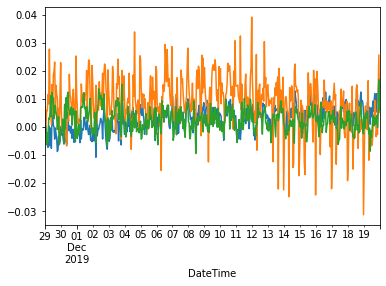

In [ ]:
all_df[all_df['station']==5]['yhat'].plot()
all_df[all_df['station']==4]['yhat'].plot()
all_df[all_df['station']==3]['yhat'].plot()

In [ ]:
print('validating...')
all_df = pd.DataFrame()

valid_start_date = pd.Timestamp('2019-10-10')
valid_end_date = valid_start_date + pd.Timedelta(int(context_length/24-1),unit='D')
pred_start_date = valid_end_date + pd.Timedelta(1,unit='D')
pred_end_date  = pred_start_date + pd.Timedelta(int(prediction_length/24-1),unit='D')
for pos in G_POST_LIST:
    out = pd.DataFrame()
    mx.random.seed(r_seed)
    np.random.seed(r_seed)
    validate_ds_pred = ListDataset([{'target': use_diff_2018_2019_df.loc[valid_start_date.strftime('%Y-%m-%d'):valid_end_date.strftime('%Y-%m-%d'),pos],
                                     'start': pd.Timestamp(pred_start_date.strftime('%Y-%m-%d'), freq=freq),
                                     FieldName.FEAT_DYNAMIC_REAL: use_diff_2018_2019_df.loc[valid_start_date.strftime('%Y-%m-%d'):pred_end_date.strftime('%Y-%m-%d'),['temp']].values.T,FieldName.FEAT_STATIC_CAT:[pos_group_dict[pos]]}]
                        ,
                    freq=freq)
    prediction = next(predictor.predict(validate_ds_pred))
    yhat_mean = prediction.mean
    out['y'] = use_diff_2018_2019_df.loc[pred_start_date.strftime('%Y-%m-%d'):pred_end_date.strftime('%Y-%m-%d'),pos]
    out['yhat'] = yhat_mean.tolist()
    out['station']=pos
    all_df = pd.concat([all_df,out],axis=0)
    calc_pred = all_df.dropna(subset=['y','yhat'],axis=0)
    error = mean_squared_error(calc_pred[calc_pred['station']==pos]['y'],calc_pred[calc_pred['station']==pos]['yhat'])*10000
    print(f'stations {pos} error is {error}')
calc_pred = all_df.dropna(subset=['y','yhat'],axis=0)
error = mean_squared_error(calc_pred['y'],calc_pred['yhat'])*10000
print('*'*20)
print(f'mean error is {error}')

validating...
stations 1 error is 0.7513425405212831
stations 2 error is 0.6258559848920595
stations 3 error is 0.6828901375577279
stations 4 error is 5.19792140164288
stations 5 error is 0.4725997540340219
stations 6 error is 6.691943631187929
stations 7 error is 1.926374176250236
stations 8 error is 1.9735486296995586
stations 9 error is 5.7855306113443286
stations 10 error is 2.9652623000390186
stations 11 error is 7.957154373799737
stations 12 error is 2.7702925204810454
stations 13 error is 20.634868746044802
stations 14 error is 2.39059021268447
stations 15 error is 3.630053459705518
stations 16 error is 1.634269652168786
stations 17 error is 0.9751535287480653
stations 18 error is 5.967079268702229
stations 19 error is 1.0666745308245844
stations 20 error is 1.6899683249023802
stations 21 error is 1.8273029800735439
stations 22 error is 2.1617451994280987
stations 23 error is 4.7562934755478015
stations 24 error is 4.312802578421894
stations 25 error is 4.394087499466223
station

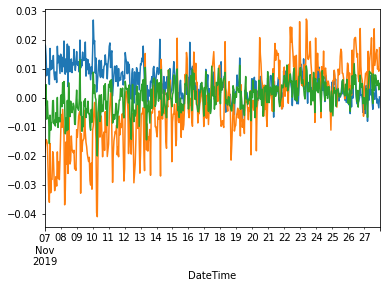

In [ ]:
all_df[all_df['station']==5]['yhat'].plot()
all_df[all_df['station']==4]['yhat'].plot()
all_df[all_df['station']==3]['yhat'].plot()

When choosing these windows we ensure that entire prediction range is always covered
by the available ground truth data, but we may chose t = 1 to lie before the start of the time series,
e.g. 2012-12-01 in the example above, padding the unobserved target with zeros

if the context period in the test data is less than the training data, zeros are padded.

In [ ]:
supplement_period = [['2020-01-02','2020-01-31'],['2020-03-02','2020-03-31'],['2020-05-02','2020-05-31'],['2020-08-01','2020-08-31']]
predict_period = [['2020-02-01','2020-02-21'],['2020-04-01','2020-04-21'],['2020-06-01','2020-06-21'],['2020-09-01','2020-09-21']]
pred_2020_all = pd.DataFrame() 


use_diff_2020_df = pressure_2020_df_diff


all_df = pd.DataFrame()
print('predicting...')
for pos in G_POST_LIST:
    print(f'predict {pos} pos')
    for s,p in zip(supplement_period,predict_period):
        out = pd.DataFrame()
        mx.random.seed(r_seed)
        np.random.seed(r_seed)
        test_data = ListDataset([{'target': use_diff_2020_df.loc[s[0]:s[1],pos], 'start': pd.Timestamp(p[0],freq=freq),FieldName.FEAT_DYNAMIC_REAL: use_diff_2020_df.loc[s[0]:p[1],['temp']].values.T,FieldName.FEAT_STATIC_CAT:[pos_group_dict[pos]]}],freq=freq)
        prediction = next(predictor.predict(test_data))
        out['DateTime'] = [pd.Timestamp(p[0])+pd.Timedelta(i,unit='H') for i in range(21*24)]
        yhat_mean = prediction.mean
        out['pressure_dff'] = yhat_mean.tolist()
        out['pressure'] = out['pressure_dff'].values+pressure_2020_df.loc[s[0]:s[1],pos].iloc[-21*24:].interpolate().values
        out['MeasName']=pos
        all_df = pd.concat([all_df,out],axis=0)
    


predicting...
predict 1 pos
predict 2 pos
predict 3 pos
predict 4 pos
predict 5 pos
predict 6 pos
predict 7 pos
predict 8 pos
predict 9 pos
predict 10 pos
predict 11 pos
predict 12 pos
predict 13 pos
predict 14 pos
predict 15 pos
predict 16 pos
predict 17 pos
predict 18 pos
predict 19 pos
predict 20 pos
predict 21 pos
predict 22 pos
predict 23 pos
predict 24 pos
predict 25 pos
predict 26 pos
predict 27 pos
predict 28 pos
predict 29 pos
predict 30 pos


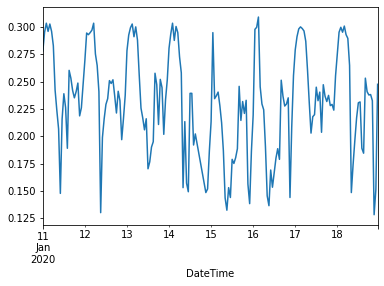

In [ ]:
pressure_2020_df.loc['2020-01-02':'2020-01-31',18].iloc[-21*24:-21*24+192].interpolate().plot() # 源数据有缺失

In [ ]:
all_df

,DateTime,pressure_dff,pressure,MeasName
0,2020-02-01 00:00:00,0.007733,0.324108,1
1,2020-02-01 01:00:00,0.005632,0.323132,1
2,2020-02-01 02:00:00,0.006803,0.330303,1
3,2020-02-01 03:00:00,0.005386,0.320636,1
4,2020-02-01 04:00:00,0.004553,0.325428,1
...,...,...,...,...
499,2020-09-21 19:00:00,0.010964,0.293339,30
500,2020-09-21 20:00:00,0.016143,0.291018,30
501,2020-09-21 21:00:00,0.012952,0.257452,30
502,2020-09-21 22:00:00,0.000294,0.260544,30


In [ ]:
final_result_for_1st_round = pd.merge(left=to_predict_df_1st[['id','MeasName','DateTime']],right =all_df[['pressure','MeasName','DateTime']],on = ['MeasName','DateTime'],how='left')

In [ ]:
final_result_for_1st_round.iloc[1168:1180]

,id,MeasName,DateTime,pressure
1168,1168,18,2020-02-04 16:00:00,0.220125
1169,1169,18,2020-02-04 17:00:00,0.215174
1170,1170,18,2020-02-04 18:00:00,0.207408
1171,1171,18,2020-02-04 19:00:00,0.203925
1172,1172,18,2020-02-04 20:00:00,0.195775
1173,1173,18,2020-02-04 21:00:00,0.190140
1174,1174,18,2020-02-04 22:00:00,0.196563
1175,1175,18,2020-02-04 23:00:00,0.225525
1176,1176,13,2020-02-04 00:00:00,0.237342
1177,1177,13,2020-02-04 01:00:00,0.245789


In [ ]:
final_result_for_1st_round[['id','pressure']].to_csv('submit_2021_01_28_1.csv',index=False)